This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

# **ReadMe**


This assignment is implemented using Anaconda with python 3.9, and the gpu environment is CUDA 10.2.95, NVIDIA GTX 1050, some important libraries' version are as follow: torch==1.10.0+cu102, torchvision==0.11.1+cu102, scikit-learn-1.0.1


Since this assignment is implemented on my local environment, if it needs to be deployed on Google Colab, the code files' location and the path_prefix parameter need to be changed.

### The Implementation of Part 4 is After the Image Reconstruction Progress


That is because the parameters returned by VAE are changed, I need to change some codes when call image reconstruction progress.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
# make sure to install the package "scikit-learn" for the progress bar when generating scatter plot for part 4
# the version of scikit-learn should be 1.0.1 to use TSNE
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage
import sys

from sklearn.manifold import TSNE

In [2]:
# path_prefix needs to be changed if running on Google Colab, this one is used for my local environment
path_prefix = "dataset"
sys.path.insert(1, path_prefix)

### Before downloading dataset:


1.Put the notebook and python files in the same folder.
2.New a folder named ***dataset*** in that folder.
3.If something wrong when downloading the dataset, try ***pip install ipywidgets***, then close notebook and reopen it after ipywidgets being installed.

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root='{}/./data'.format(path_prefix),  train=True,download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to dataset/./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to dataset/./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to dataset/./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to dataset/./data\FashionMNIST\raw



## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


## This is my Autoencoder for part 1:

In [4]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(28*28, output_size)

            def forward(self, x):
                # needs your implementation
                x = x.view(-1, 28*28)
                x = self.fc(x)
                return x

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(input_size, 28*28)
                self.trans = nn.Sigmoid()

            def forward(self, z):
                # needs your implementation
                z = self.fc(z)
                z = self.trans(z)
                z = z.reshape((z.shape[0], 1, 28, 28))
                return z

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)


    def forward(self, x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

## This is my Autoencoder for part 2:

In [3]:
class Autoencoder(nn.Module):

    def __init__(self, dim_latent_representation=2):

        super(Autoencoder, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=2):
                super(Encoder, self).__init__()
                # needs your implementation
                self.l1 = nn.Linear(28*28, 1024)
                self.relu = nn.ReLU()
                self.l2 = nn.Linear(1024, output_size)

            def forward(self, x):
                # needs your implementation
                x = x.view(-1, 28*28)
                x = self.l1(x)
                x = self.relu(x)
                x = self.l2(x)

                return x

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                self.l1 = nn.Linear(input_size, 1024)
                self.relu = nn.ReLU()
                self.l2 = nn.Linear(1024, 28*28)

                self.trans = nn.Sigmoid()

            def forward(self, z):
                # needs your implementation
                z = self.l1(z)
                z = self.relu(z)
                z = self.l2(z)
                z = self.trans(z)
                z = z.reshape((z.shape[0], 1, 28, 28))
                return z

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)


    def forward(self, x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

## Training the Model for Part 1 / Part 2

The parameter dim_latent_representation is changed for Part 3. The training progress for Part 3 is after the DAE model.

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.


Since the training process for autoencoder of part 1 and autoencoder of part 2 are the same, so I put training process here.


The hyper-parameter LEARNING_RATE=5e-3 and EPOCH_NUMBER = 10 could be better for training autoencoder of part 1 (sometimes overfitting and EPOCH_NUMBER = 6 will not overfit, but EPOCH_NUMBER = 10 could get better result when it doesn't overfit), but will be bad for part 2. Since the assignment instruction asks us to explain the result, to avoid the other variable's influence (network architecture should be the only one variable in the experiment), I keep the learning rate and epoch number the same as default ones.

In [4]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3 # 5e-3
EPOCH_NUMBER= 10 # 10 # the number of epochs and learning rate can be tuned.

dim_latent = 2

autoencoder = Autoencoder(dim_latent_representation=dim_latent)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder, learning_rate=LEARNING_RATE, path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:12<00:00, 147.24it/s]


====> Epoch: 1 Average loss: 0.6899


100%|██████████| 313/313 [00:03<00:00, 85.55it/s] 


====> Val set loss (reconstruction error) : 0.6684


100%|██████████| 1875/1875 [00:10<00:00, 175.70it/s]


====> Epoch: 2 Average loss: 0.6624


100%|██████████| 313/313 [00:03<00:00, 84.41it/s] 


====> Val set loss (reconstruction error) : 0.6579


100%|██████████| 1875/1875 [00:11<00:00, 169.23it/s]


====> Epoch: 3 Average loss: 0.6571


100%|██████████| 313/313 [00:03<00:00, 85.21it/s] 


====> Val set loss (reconstruction error) : 0.6535


100%|██████████| 1875/1875 [00:11<00:00, 167.92it/s]


====> Epoch: 4 Average loss: 0.6548


100%|██████████| 313/313 [00:03<00:00, 81.30it/s] 


====> Val set loss (reconstruction error) : 0.6521


100%|██████████| 1875/1875 [00:11<00:00, 169.74it/s]


====> Epoch: 5 Average loss: 0.6532


100%|██████████| 313/313 [00:03<00:00, 79.25it/s] 


====> Val set loss (reconstruction error) : 0.6512


100%|██████████| 1875/1875 [00:10<00:00, 173.18it/s]


====> Epoch: 6 Average loss: 0.6519


100%|██████████| 313/313 [00:03<00:00, 85.08it/s] 


====> Val set loss (reconstruction error) : 0.6508


100%|██████████| 1875/1875 [00:10<00:00, 173.01it/s]


====> Epoch: 7 Average loss: 0.6511


100%|██████████| 313/313 [00:03<00:00, 85.95it/s] 


====> Val set loss (reconstruction error) : 0.6502


100%|██████████| 1875/1875 [00:11<00:00, 167.25it/s]


====> Epoch: 8 Average loss: 0.6506


100%|██████████| 313/313 [00:03<00:00, 86.26it/s] 


====> Val set loss (reconstruction error) : 0.6488


100%|██████████| 1875/1875 [00:10<00:00, 174.27it/s]


====> Epoch: 9 Average loss: 0.6497


100%|██████████| 313/313 [00:03<00:00, 83.02it/s] 


====> Val set loss (reconstruction error) : 0.6488


100%|██████████| 1875/1875 [00:13<00:00, 138.58it/s]


====> Epoch: 10 Average loss: 0.6493


100%|██████████| 313/313 [00:05<00:00, 52.59it/s] 

====> Val set loss (reconstruction error) : 0.6483


## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

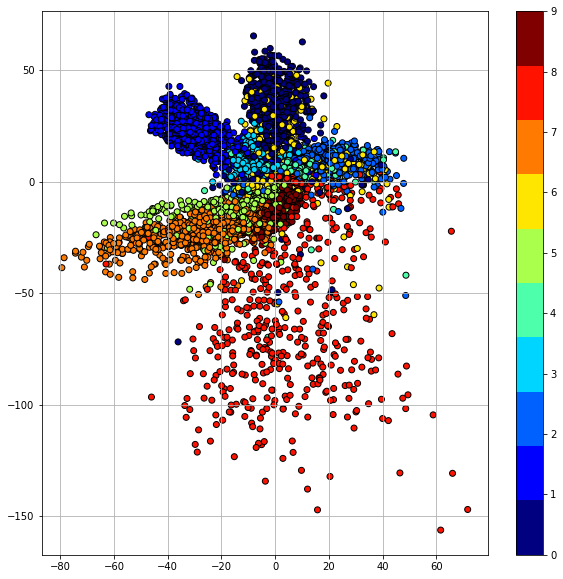

In [5]:
from autoencoder_starter import scatter_plot

with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

scatter_plot(latent_representations=z,labels=label)

## This is my Autoencoder for part 3:

In [4]:
class DAE(nn.Module):

    def __init__(self, dim_latent_representation=30, noise='Gaussian'):

        super(DAE, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=30, noise_type='Gaussian'):
                super(Encoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(28*28, output_size)
                self.noise = noise_type

            def forward(self, x):
                # needs your implementation
                x = x.view(-1, 28*28)
                x = DAE.add_noise(self, x, noise)
                x = self.fc(x)
                return x

        class Decoder(nn.Module):
            def __init__(self, input_size=30):
                super(Decoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(input_size, 28 * 28)
                self.trans = nn.Tanh()

            def forward(self, z):
                # needs your implementation
                z = self.fc(z)
                z = self.trans(z)
                z = z.reshape((z.shape[0], 1, 28, 28))
                return z

        self.encoder = Encoder(output_size=dim_latent_representation, noise_type=noise)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    def add_noise(self, x, noise_type):
        if noise_type=='Gaussian':
            if self.training:
                if torch.cuda.is_available():
                    device = 'cuda:0'
                else:
                    device = 'cpu'
                gaussian = torch.randn(x.shape)
                gaussian = gaussian.to(device)
                return torch.add(x, gaussian)
            else:
                return x
        elif noise_type=='Dropout':
            dropout = nn.Dropout(p=0.1)
            x = dropout(x)
            return x
        else:
            return x

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

## Training the Model for Part 3

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

### Without Noise:

In [5]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER = 10  # the number of epochs and learning rate can be tuned.

dim_latent = 30

dae = DAE(dim_latent_representation=dim_latent, noise='None')
trainer = Autoencoder_Trainer(autoencoder_model=dae, learning_rate=LEARNING_RATE, path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
    print("Manual Interruption")

100%|██████████| 1875/1875 [00:10<00:00, 180.37it/s]


====> Epoch: 1 Average loss: 0.5807


100%|██████████| 313/313 [00:03<00:00, 84.69it/s] 


====> Val set loss (reconstruction error) : 0.5266


100%|██████████| 1875/1875 [00:09<00:00, 195.35it/s]


====> Epoch: 2 Average loss: 0.5167


100%|██████████| 313/313 [00:03<00:00, 85.36it/s] 


====> Val set loss (reconstruction error) : 0.5080


100%|██████████| 1875/1875 [00:08<00:00, 228.04it/s]


====> Epoch: 3 Average loss: 0.5061


100%|██████████| 313/313 [00:03<00:00, 85.81it/s] 


====> Val set loss (reconstruction error) : 0.5031


100%|██████████| 1875/1875 [00:07<00:00, 236.39it/s]


====> Epoch: 4 Average loss: 0.5034


100%|██████████| 313/313 [00:03<00:00, 83.82it/s] 


====> Val set loss (reconstruction error) : 0.5018


100%|██████████| 1875/1875 [00:08<00:00, 218.67it/s]


====> Epoch: 5 Average loss: 0.5027


100%|██████████| 313/313 [00:03<00:00, 82.44it/s] 


====> Val set loss (reconstruction error) : 0.5015


100%|██████████| 1875/1875 [00:08<00:00, 222.82it/s]


====> Epoch: 6 Average loss: 0.5024


100%|██████████| 313/313 [00:03<00:00, 92.28it/s] 


====> Val set loss (reconstruction error) : 0.5013


100%|██████████| 1875/1875 [00:08<00:00, 221.98it/s]


====> Epoch: 7 Average loss: 0.5022


100%|██████████| 313/313 [00:03<00:00, 90.79it/s] 


====> Val set loss (reconstruction error) : 0.5012


100%|██████████| 1875/1875 [00:08<00:00, 224.65it/s]


====> Epoch: 8 Average loss: 0.5021


100%|██████████| 313/313 [00:03<00:00, 96.45it/s] 


====> Val set loss (reconstruction error) : 0.5012


100%|██████████| 1875/1875 [00:08<00:00, 229.26it/s]


====> Epoch: 9 Average loss: 0.5021


100%|██████████| 313/313 [00:03<00:00, 84.75it/s] 


====> Val set loss (reconstruction error) : 0.5011


100%|██████████| 1875/1875 [00:07<00:00, 237.34it/s]


====> Epoch: 10 Average loss: 0.5020


100%|██████████| 313/313 [00:03<00:00, 91.53it/s] 

====> Val set loss (reconstruction error) : 0.5011


### With Noise Turning Some Input Noise to 0:

In [5]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER = 10  # the number of epochs and learning rate can be tuned.

dim_latent = 30

dae = DAE(dim_latent_representation=dim_latent, noise='Dropout')
trainer = Autoencoder_Trainer(autoencoder_model=dae, learning_rate=LEARNING_RATE, path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
    print("Manual Interruption")

100%|██████████| 1875/1875 [00:11<00:00, 160.76it/s]


====> Epoch: 1 Average loss: 0.5812


100%|██████████| 313/313 [00:04<00:00, 74.60it/s] 


====> Val set loss (reconstruction error) : 0.5287


100%|██████████| 1875/1875 [00:08<00:00, 222.01it/s]


====> Epoch: 2 Average loss: 0.5204


100%|██████████| 313/313 [00:03<00:00, 89.55it/s] 


====> Val set loss (reconstruction error) : 0.5128


100%|██████████| 1875/1875 [00:08<00:00, 214.76it/s]


====> Epoch: 3 Average loss: 0.5106


100%|██████████| 313/313 [00:03<00:00, 83.76it/s] 


====> Val set loss (reconstruction error) : 0.5076


100%|██████████| 1875/1875 [00:08<00:00, 211.11it/s]


====> Epoch: 4 Average loss: 0.5077


100%|██████████| 313/313 [00:03<00:00, 89.39it/s] 


====> Val set loss (reconstruction error) : 0.5062


100%|██████████| 1875/1875 [00:08<00:00, 210.10it/s]


====> Epoch: 5 Average loss: 0.5069


100%|██████████| 313/313 [00:03<00:00, 86.52it/s] 


====> Val set loss (reconstruction error) : 0.5062


100%|██████████| 1875/1875 [00:08<00:00, 209.90it/s]


====> Epoch: 6 Average loss: 0.5065


100%|██████████| 313/313 [00:03<00:00, 90.33it/s] 


====> Val set loss (reconstruction error) : 0.5054


100%|██████████| 1875/1875 [00:08<00:00, 222.70it/s]


====> Epoch: 7 Average loss: 0.5064


100%|██████████| 313/313 [00:03<00:00, 80.64it/s] 


====> Val set loss (reconstruction error) : 0.5054


100%|██████████| 1875/1875 [00:08<00:00, 222.29it/s]


====> Epoch: 8 Average loss: 0.5063


100%|██████████| 313/313 [00:03<00:00, 82.85it/s] 


====> Val set loss (reconstruction error) : 0.5057


100%|██████████| 1875/1875 [00:08<00:00, 222.55it/s]


====> Epoch: 9 Average loss: 0.5062


100%|██████████| 313/313 [00:03<00:00, 88.02it/s] 


====> Val set loss (reconstruction error) : 0.5053


100%|██████████| 1875/1875 [00:08<00:00, 211.74it/s]


====> Epoch: 10 Average loss: 0.5061


100%|██████████| 313/313 [00:03<00:00, 84.45it/s] 

====> Val set loss (reconstruction error) : 0.5050


### With Gaussian Noise:

In [5]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER = 10  # the number of epochs and learning rate can be tuned.

dim_latent = 30

dae = DAE(dim_latent_representation=dim_latent, noise='Gaussian')
trainer = Autoencoder_Trainer(autoencoder_model=dae, learning_rate=LEARNING_RATE, path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
    print("Manual Interruption")

100%|██████████| 1875/1875 [00:10<00:00, 178.37it/s]


====> Epoch: 1 Average loss: 0.6017


100%|██████████| 313/313 [00:03<00:00, 91.21it/s] 


====> Val set loss (reconstruction error) : 0.5355


100%|██████████| 1875/1875 [00:08<00:00, 211.87it/s]


====> Epoch: 2 Average loss: 0.5425


100%|██████████| 313/313 [00:03<00:00, 90.64it/s] 


====> Val set loss (reconstruction error) : 0.5189


100%|██████████| 1875/1875 [00:09<00:00, 206.93it/s]


====> Epoch: 3 Average loss: 0.5340


100%|██████████| 313/313 [00:03<00:00, 84.59it/s] 


====> Val set loss (reconstruction error) : 0.5125


100%|██████████| 1875/1875 [00:09<00:00, 206.78it/s]


====> Epoch: 4 Average loss: 0.5311


100%|██████████| 313/313 [00:03<00:00, 88.68it/s] 


====> Val set loss (reconstruction error) : 0.5112


100%|██████████| 1875/1875 [00:08<00:00, 212.36it/s]


====> Epoch: 5 Average loss: 0.5303


100%|██████████| 313/313 [00:03<00:00, 87.75it/s] 


====> Val set loss (reconstruction error) : 0.5118


100%|██████████| 1875/1875 [00:08<00:00, 217.37it/s]


====> Epoch: 6 Average loss: 0.5301


100%|██████████| 313/313 [00:04<00:00, 70.84it/s] 


====> Val set loss (reconstruction error) : 0.5107


100%|██████████| 1875/1875 [00:08<00:00, 210.57it/s]


====> Epoch: 7 Average loss: 0.5299


100%|██████████| 313/313 [00:04<00:00, 77.15it/s] 


====> Val set loss (reconstruction error) : 0.5112


100%|██████████| 1875/1875 [00:09<00:00, 194.64it/s]


====> Epoch: 8 Average loss: 0.5298


100%|██████████| 313/313 [00:03<00:00, 82.04it/s] 


====> Val set loss (reconstruction error) : 0.5105


100%|██████████| 1875/1875 [00:09<00:00, 206.18it/s]


====> Epoch: 9 Average loss: 0.5298


100%|██████████| 313/313 [00:03<00:00, 85.29it/s] 


====> Val set loss (reconstruction error) : 0.5105


100%|██████████| 1875/1875 [00:09<00:00, 199.85it/s]


====> Epoch: 10 Average loss: 0.5297


100%|██████████| 313/313 [00:03<00:00, 87.36it/s] 

====> Val set loss (reconstruction error) : 0.5111


## Generating Kernel Plot and Show

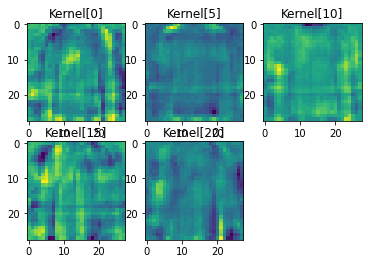

In [6]:
from autoencoder_starter import Plot_Kernel

with torch.no_grad():
    model = trainer.model
    model.eval()
    z = []
    label = []
    for x, y in trainer.val_loader:
        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)
    Plot_Kernel(model)

### Since the image reconstruction can be used commonly by part 1, 2 and 3, so I import the function from the related autoencoder_starter_2_x.py in the training part, and put the call of function here.

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


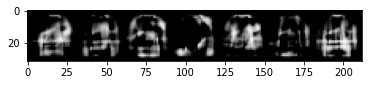

In [7]:
from autoencoder_starter import display_images_in_a_row

with torch.no_grad():
    samples = torch.randn(7, dim_latent).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


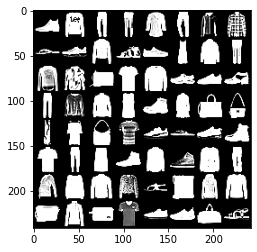

In [7]:
from autoencoder_starter import display_images_in_a_row

images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


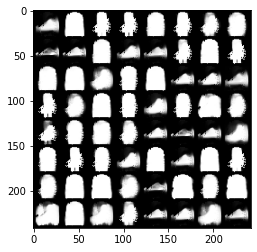

In [8]:
from autoencoder_starter import display_images_in_a_row

with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

## This is my Autoencoder for part 4:


This VAE class will return following parameters: model_x, mu, logvar, bseweight, kldweight

In [4]:
class VAE(nn.Module):

    def __init__(self, dim_latent_representation=30):

        super(VAE, self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size=30):
                super(Encoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(28*28, output_size)
                # self.mean = nn.Linear(output_size, output_size, bias=False)
                self.mean = nn.Linear(output_size, output_size)

                # Since it doesn't tell us whether we could use activation function for std layer,
                # to make sure all std > 0, and simplify the calculation of KL divergency
                # I train logstd2(which is log(std^2)), and calculate std using logstd2
                # self.logstd2 = nn.Linear(output_size, output_size, bias=False)
                self.logstd2 = nn.Linear(output_size, output_size)

            def forward(self, x):
                # needs your implementation
                x = x.view(-1, 28*28)
                x = self.fc(x)
                mean_out = self.mean(x)
                # logstd2 represents log(std^2)
                logstd2_out = self.logstd2(x)
                return mean_out, logstd2_out

        class Decoder(nn.Module):
            def __init__(self, input_size=30):
                super(Decoder, self).__init__()
                # needs your implementation
                self.fc = nn.Linear(input_size, 28 * 28)
                self.trans = nn.Tanh()

            def forward(self, z):
                # needs your implementation
                z = self.fc(z)
                z = self.trans(z)
                z = z.reshape((z.shape[0], 1, 28, 28))
                return z

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.bseweight = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.kldweight = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        if self.training:
            # Since, make z belongs to N(mu, var^2)
            # is equal to z = mu + eps * var and eps belongs to N(0,1)
            # to simplify the calculation, my logvar is not log(std), it is log(std^2)
            eps = torch.normal(mean=0, std=1, size=logvar.shape)
            if torch.cuda.is_available():
                device = 'cuda:0'
            else:
                device = 'cpu'
            eps = eps.to(device)
            reparameter = mu + torch.exp(torch.div(logvar, 2)) * eps
            return reparameter
        else:
            return mu

    def forward(self, x):
        # This function should be modified for the DAE and VAE
        bseweight = self.bseweight.data.fill_(0.8)
        # kld need a weight about 0 to warm up, otherwise, it will overfit
        kldweight = self.kldweight.data.fill_(0.0001)
        mu, logvar = self.encoder(x)
        latent_z = self.reparameterise(mu=mu, logvar=logvar)
        x = self.decoder(latent_z)
        # for the VAE forward function should also return mu and logvar
        return x, mu, logvar, bseweight, kldweight

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [5]:
from VAE_starter import VAE_Trainer

LEARNING_RATE = 1e-3  
EPOCH_NUMBER = 10  # the number of epochs and learning rate can be tuned.

vae = VAE(dim_latent_representation=30)
trainer = VAE_Trainer(vae_model=vae, learning_rate=LEARNING_RATE, path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
    print("Manual Interruption")

100%|██████████| 1875/1875 [00:21<00:00, 88.47it/s] 


====> Epoch: 1 Average loss: 0.5837


100%|██████████| 313/313 [00:04<00:00, 71.89it/s] 


====> Val set loss (reconstruction error) : 0.5018


100%|██████████| 1875/1875 [00:12<00:00, 144.71it/s]


====> Epoch: 2 Average loss: 0.5165


100%|██████████| 313/313 [00:04<00:00, 78.11it/s] 


====> Val set loss (reconstruction error) : 0.4862


100%|██████████| 1875/1875 [00:11<00:00, 164.41it/s]


====> Epoch: 3 Average loss: 0.5073


100%|██████████| 313/313 [00:04<00:00, 72.13it/s] 


====> Val set loss (reconstruction error) : 0.4875


100%|██████████| 1875/1875 [00:12<00:00, 152.43it/s]


====> Epoch: 4 Average loss: 0.5043


100%|██████████| 313/313 [00:03<00:00, 79.47it/s] 


====> Val set loss (reconstruction error) : 0.4854


100%|██████████| 1875/1875 [00:11<00:00, 158.01it/s]


====> Epoch: 5 Average loss: 0.5023


100%|██████████| 313/313 [00:03<00:00, 86.54it/s] 


====> Val set loss (reconstruction error) : 0.4821


100%|██████████| 1875/1875 [00:12<00:00, 146.73it/s]


====> Epoch: 6 Average loss: 0.5014


100%|██████████| 313/313 [00:03<00:00, 84.32it/s] 


====> Val set loss (reconstruction error) : 0.4814


100%|██████████| 1875/1875 [00:12<00:00, 155.22it/s]


====> Epoch: 7 Average loss: 0.5006


100%|██████████| 313/313 [00:03<00:00, 93.17it/s] 


====> Val set loss (reconstruction error) : 0.4808


100%|██████████| 1875/1875 [00:10<00:00, 177.61it/s]


====> Epoch: 8 Average loss: 0.5003


100%|██████████| 313/313 [00:03<00:00, 87.34it/s] 


====> Val set loss (reconstruction error) : 0.4828


100%|██████████| 1875/1875 [00:11<00:00, 170.07it/s]


====> Epoch: 9 Average loss: 0.5001


100%|██████████| 313/313 [00:03<00:00, 97.35it/s] 


====> Val set loss (reconstruction error) : 0.4813


100%|██████████| 1875/1875 [00:10<00:00, 183.02it/s]


====> Epoch: 10 Average loss: 0.4999


100%|██████████| 313/313 [00:03<00:00, 89.72it/s] 

====> Val set loss (reconstruction error) : 0.4803


## Using TSNE Transformation to Visualize 30 Dimensional Vectors in 2D Scatter.

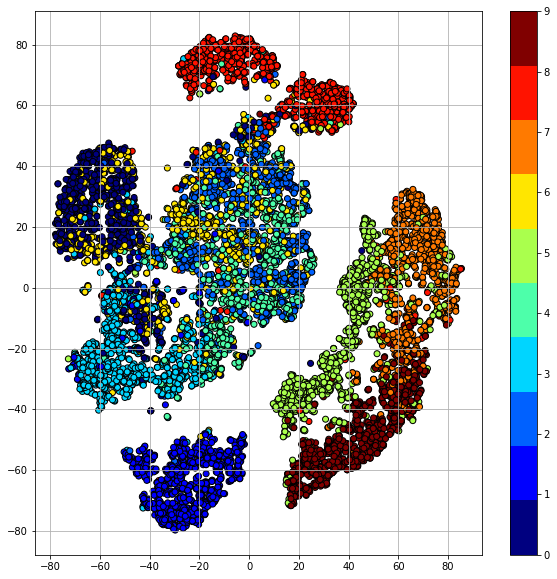

In [7]:
from VAE_starter import scatter_plot_TSNE
from sklearn.manifold import TSNE

with torch.no_grad():
    model = trainer.model
    model.eval()
    z = []
    label = []
    for x, y in trainer.val_loader:
        z_, logstd2 = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

scatter_plot_TSNE(latent_representations=z, labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


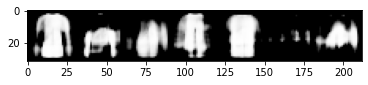

In [8]:
from VAE_starter import display_images_in_a_row

with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


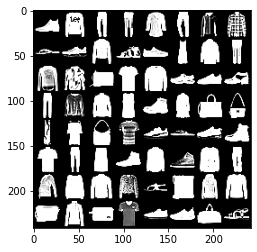

In [9]:
from VAE_starter import display_images_in_a_row

images = trainer.get_val_set()  # get the entire validation set
total_number = 64
images = images[:total_number]

print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


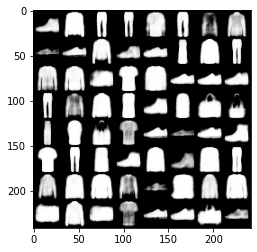

In [10]:
from VAE_starter import display_images_in_a_row

with torch.no_grad():
    images = images.to(trainer.device)
    # reconstructed = trainer.model(images).cpu()
    reconstructed, mu, logvar, bseweight, kldweight = trainer.model(images)
    reconstructed = reconstructed.cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

## I Use DAE without Noise for Making Comparation with VAE in Part 4:


As the assignment instruction says we should make a comparation between VAE and an autoencoder with similar architecture except the VAE's special features, the autoencoder in part 3 using "without noise" mode is just what required in part 4, and I use that model then call TSNE transform to generate scatter plot and compare it with the one generated by VAE in part 4.

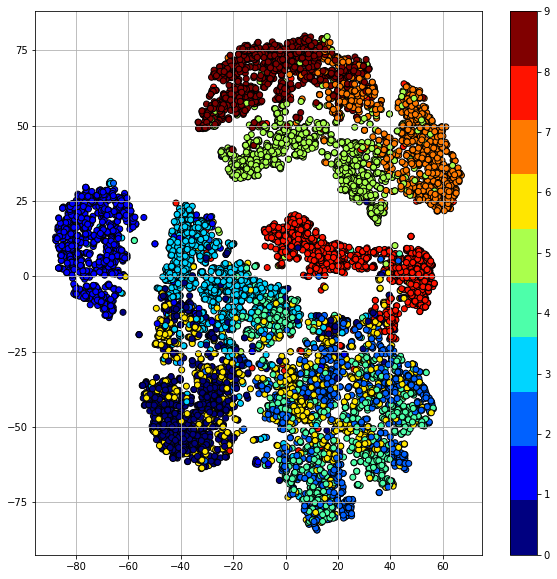

In [9]:
from VAE_starter import scatter_plot_TSNE
from sklearn.manifold import TSNE

with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

scatter_plot_TSNE(latent_representations=z, labels=label)